# Exercise 5: Sinusoidal model

In this exercise you will experiment with the sinusoidal model, measuring and tracking sinusoids in different kinds of audio signals. You will use the sinusoidal model to analyze short synthetic sounds with the goal to better understand various aspects of sinusoid estimation and tracking. You will experiment with different parameters and enhancements of the sinusoidal modeling approach. 

There are four parts in this exercise: 1) Minimizing the frequency estimation error of a sinusoid, 2) Tracking a two component chirp, 3) Tracking sinusoids of different amplitudes, and 4) Sinusoidal modeling of a multicomponent signal.

### Relevant Concepts

__Chirp signals:__
A chirp is a signal whose frequency varies with time. In an up-chirp, the frequency increases in time. In Part 2 of the exercise, we will use a synthetically generated linear chirp with two frequency components. The frequency components are very close to each other and to resolve the two components, you need to use a large window. However, the frequency of a chirp continuously changes, which implies that we need a shorter window for analysis to capture this continuously changing frequency. Hence, there exists a tradeoff between the best set of sinusoidal analysis parameters to achieve a good tracking of the two components of the chirp. 

__Sinusoidal modeling and sine tracking:__ 
Sinusoidal modeling aims to model each frame of audio with a set of sinusoids, from which we can reconstruct the input audio with minimum reconstruction error. The basic peak detection task performed in the spectrum of a frame can be enhanced in many ways to obtain the most compact representation possible and the most meaningful one for a particular task. One of the enhancements implemented in sms-tools is the tracking of the estimated sinusoids over time. In sounds with stable notes, the sinusoids tend to last over several frames and this can be used to discard spurious sinusoids that have been estimated. There are two functions in `sineModel.py` that together perform sine tracking. The function `sineTracking()` tracks peaks from one frame to the next, to give tracks of the sinusoids in time. The function `cleaningSineTracks()` then cleans up the tracks by discarding short spurious sinusoids based on a length threshold. These functions use the following parameters to do sine tracking. 

1. `maxnSines`: Maximum number of sines tracked per frame.
2. `minSineDur`: Minimum duration of a sinusoidal track in seconds.
3. `freqDevOffset`: The minimum frequency deviation at 0Hz. Since the frequency of sinusoidal tracks can change slowly over time, it is necessary to have a margin of allowed deviation to track the change over time. 
4. `freqDevSlope`: Slope increase of minimum frequency deviation. The common deviations are  more pronounced at higher frequency and we compensate for that using a scaling factor, which provides a higher deviation allowance at higher frequencies. 

If we set `minSineDur = 0`, it retains all the spectral peaks detected. `maxnSines` can be set according to our prior knowledge about the number of sinusoids present in the signal. `freqDevOffset` intuitively can be set to be the minimum distance between two consecutive sinusoids (or harmonics in the case of harmonic sounds).

__Tracking low amplitude sinusoids:__
Tracking sinusoids of low amplitude among other sinusoids of high amplitude presents several challenges. In a signal that has two sinusoidal components with a very large difference in their amplitude, the analysis window we use is critical. If we use a window that has high sidelobe levels, the mainlobe of the sinusoid with low amplitude might get buried under the sidelobes of the dominant high amplitude sinusoid. When the amplitude difference is huge you need to choose a window that will ensure that the sidelobe levels of the louder sinusoid is lower than the mainlobe level of the softer sinusoid. 

## Part 1 - Minimizing the frequency estimation error of a sinusoid

The function `min_freq_est_err()` should estimate the frequency of a sinusoidal signal at a given time instant. The function should return the estimated frequency in Hz, together with the window size and the FFT size used in the analysis.  

The input arguments to the function are the wav file name including the path (`input_file`) containing the sinusoidal signal, and the frequency of the sinusoid in Hz (`f`). The frequency of the input sinusoid can range between 100Hz and 2000Hz. The function should return a three element tuple of the estimated frequency of the sinusoid (`f_est`), the window size (`M`), and the FFT size (`N`) used.

The input wav file should be a stationary audio signal consisting of a single sinusoid of length >=1 second. Since the signal is stationary you can just perform the analysis of a single frame, for example in the middle of the sound file (time equal to .5 seconds). The analysis process would be to first select a fragment of the signal equal to the window size, `M`, centered at .5 seconds, then compute the DFT using the `dftAnal()` function, and finally use the `peakDetection()` and `peakInterp()` functions to obtain the frequency value of the sinusoid.

Use a Blackman window for analysis and a magnitude threshold `t = -40`dB for peak picking. The window size and FFT size should be chosen such that the difference between the true frequency (`f`) and the estimated frequency (`fEst`) is less than 0.05 Hz for the entire allowed frequency range of the input sinusoid. The window size should be the minimum positive integer of the form `100*k + 1` (where `k` is a positive integer) for which the frequency estimation error is < 0.05Hz. For a window size `M`, take the FFT size (`N`) to be the smallest power of 2 larger than `M`. 

HINT: Computing `M` theoritically using a formula might be complex in such cases. Instead, you need to follow a heuristic approach to determine the optimal value of `M` and `N` for a particular `f`. You can iterate over all allowed values of window size `M` and stop when the condition is satisfied (i.e. the frequency estimation error < 0.05 Hz).

In [38]:
import numpy as np
from scipy.signal import get_window, find_peaks
from scipy.fftpack import fft, fftshift
import math
import sys, os
sys.path.append('/content/sms-tools/software/models/')
import dftModel as DFT
import utilFunctions as UF
import stft
import sineModel as SM
import IPython.display as ipd

In [ ]:
# E5 - 1.1: Complete the function min_freq_est_err()

def min_freq_est_err(input_file, f):
    """Best estimate the frequency of a sinusoid by iterating over different sizes of analysis window.
    
    Args:
            input_file (str): wav file
            f (float): frequency of the sinusoid present in the input audio signal (Hz)
            
    Result:
            f_est (float): estimated frequency of the sinusoid (Hz)
            M (int): Window size
            N (int): FFT size
            
    """
    # analysis parameters:
    window = 'blackman'
    t = -40
 
    fs, x = UF.wavread(input_file)
    k = 1
    dif = 1
    while dif > 0.05:
        M = 100*k+1 
        N = int(pow(2, np.ceil(np.log2(M)))) 
        w = get_window(window,M)

        x1 = x[((fs//2)-((M-1)//2)):(fs//2)+((M+1)//2)]

        mX, pX = DFT.dftAnal(x1, w, N)
        ploc = UF.peakDetection(mX, t)
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)
        f_est = (iploc[0]/N)*fs
        dif = abs(f_est-f)
       
    return M, N, f_est, dif


Test cases for `min_freq_est_err()`:

__Test case 1:__ If you run your code with `input_file = '../sounds/sine-490.wav'`, `f = 490.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 489.963` and the frequency estimation error is 0.037.

__Test case 2:__ If you run your code with `input_file = '../sounds/sine-1000.wav'`, `f = 1000.0` Hz, the optimal
values are `M = 1101`, `N = 2048`, `f_est = 1000.02` and the frequency estimation error is 0.02.

__Test case 3:__ If you run your code with `input_file = '../sounds/sine-200.wav'`, `f = 200.0 Hz`, the optimal
values are `M = 1201`, `N = 2048`, `f_est = 200.038` and the frequency estimation error is 0.038.

Interesting validation is to check if these frequency estimation errors are perceptually relevant. To do that you can generate and listen the estimated frequencies, by generating a sinusoid with that frequency, and check if you perceive a difference with the original sinusoid.

In [72]:
# E5 - 1.2: For each of the 3 test cases, play the input sinusoid, call the function min_freq_est_err(),  
# generate sinusoid with estimated frequency value, and play it. Explain the result.

### Your code here

#test1

fs, x1 = UF.wavread('../sounds/sine-490.wav')
t = np.arange(10000)/fs
print('original freq')
ipd.display(ipd.Audio(data=x1, rate=fs))
M,N,f_est,error = min_freq_est_err('../sounds/sine-490.wav', 490.0)
xx1 = np.sin(2*np.pi*f_est*t)
print('estimated freq')
ipd.display(ipd.Audio(data=xx1, rate=fs))
print('M:',M)
print('N:',N)
print('freq estim:',f_est)

#test 2

fs, x2 = UF.wavread('../sounds/sine-1000.wav')
t = np.arange(10000)/fs
print('original freq')
ipd.display(ipd.Audio(data=x2, rate=fs))
M,N,f_est,error = min_freq_est_err('../sounds/sine-1000.wav', 1000.0)
xx2 = np.sin(2*np.pi*f_est*t)
print('estimated freq')
ipd.display(ipd.Audio(data=xx2, rate=fs))
print('M:',M)
print('N:',N)
print('freq estim:',f_est)

#test 3

fs, x3 = UF.wavread('../sounds/sine-1000.wav')
t = np.arange(10000)/fs
print('original freq')
ipd.display(ipd.Audio(data=x3, rate=fs))
M,N,f_est,error = min_freq_est_err('../sounds/sine-200.wav', 200.0)
xx2 = np.sin(2*np.pi*f_est*t)
print('estimated freq')
ipd.display(ipd.Audio(data=xx3, rate=fs))
print('M:',M)
print('N:',N)
print('freq estim:',f_est)

""" Explanation
Primer llegim el so i l'escoltem.
Després cridem la funció min_freq_est_err() amb el fitxer i la freqüència determinada i obtenim els paràmetres com M i la freq estimada.
Un cop tenim la freq estimada creem un sinudoide amb aquesta freq i l'escoltem.
"""


original freq


KeyboardInterrupt: 

## Part 2 - Tracking a two component chirp 

In this part you should perform the best possible sinusoidal analysis of a two component chirp signal by focusing on the window-size, `M`, of the function `sineModelAnal()`. 

You should use the sound `chirp-150-190-linear.wav`, which is a linear chirp with two sinusoids with starting frequencies of 150Hz and 190Hz, and finishing at 1400Hz and 1440Hz after 2 seconds. The estimation and tracking of the two varying frequencies should result in a mean error smaller than 2Hz. 

Several functions are already defined to do this part of the exercise. Read them and understand what they do. The function `freq_tracker_error()` performs a sinusoidal analysis using the `sineModelAnal()` function, then compares the analysis results, `fTrackEst`, with the ideal frequency values, given as input, and returns the mean error `meanErr`. 

Get familiar with the signal by listening to the sound and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. 

In [43]:
# functions used in exercises of Part 2 and 3

def gen_time_stamps(xlen, M, fs, H):
    """Generate frame time stamps for a given sound duration.
    
    Args:
        xlen (float): duration of sound in seconds
        M (int): window size
        fs (int): sampling rate 
        H (int): hop size
        
    Result:
        np.array: time stamps
        
    """
    hM1 = int(np.floor((M+1)/2))                     
    hM2 = int(np.floor(M/2))                         
    xlen = xlen + 2*hM2
    pin = hM1
    pend = xlen - hM1                                     
    tStamps = np.arange(pin,pend,H)/float(fs)
    return tStamps

def gen_true_freq_tracks_chirp_150_190(tStamps):
    """Generate the frequency values present in file "../sounds/chirp-150-190-linear.wav"
    
    Args: 
        tStamps (np.array): time stamps
        
    Result:
        np.array: time stamps and frequency values of predefined chirp
        
    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(np.linspace(190, 190+1250, len(tStamps)))
    fTrack[:,1] = np.transpose(np.linspace(150, 150+1250, len(tStamps)))
    return fTrack

def gen_true_freq_tracks_440_602(tStamps):
    """Generate the frequency values present in file "../sounds/sines-440-602-hRange.wav"
    
    Args: 
        tStamps (np.array): time stamps
        
    Result:
        np.array: time stamps and frequency values of predefined chirp
        
    """
    fTrack = np.zeros((len(tStamps),2))
    fTrack[:,0] = np.transpose(440*np.ones((len(tStamps),1)))
    fTrack[:,1] = np.transpose(602*np.ones((len(tStamps),1)))
    return fTrack

def freq_tracker_error(input_file, fTrackTrue, window, t, H, M):
    """Estimate sinusoidal values of a sound
    
    Args:
        input_file (str): wav file including the path
        fTrackTrue (np.array): array of true frequency values, one row per time frame, one column per component
        window (str): window type used for analysis
        t (float): peak picking threshold (negative dB)
        H (int): hop size in samples
        M (int): window size in samples
           
   Result:
           float: mean estimation error
           np.array: estimated frequency values, one row per time frame, one column per component
           
    """
  
    N = int(pow(2, np.ceil(np.log2(M))))        # FFT Size, power of 2 larger than M
    maxnSines = 2                               # Maximum number of sinusoids at any time frame
    minSineDur = 0.0                            # minimum duration set to zero to not do tracking
    freqDevOffset = 30                          # minimum frequency deviation at 0Hz
    freqDevSlope = 0.001                        # slope increase of minimum frequency deviation
    
    fs, x = UF.wavread(input_file)              # read input sound
    w = get_window(window, M)                   # Compute analysis window
    # analyze the sound with the sinusoidal model
    fTrackEst, mTrackEst, pTrackEst = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)
    tailF = 20                                 
    # Compute mean estimation error. 20 frames at the beginning and end not used to compute error
    meanErr = np.mean(np.abs(fTrackTrue[tailF:-tailF,:] - fTrackEst[tailF:-tailF,:]),axis=0)        
    
    return (meanErr, fTrackEst)

The most important input parameter of the function `freq_tracker_error()` in order to obtain the best possible results, that is, minimum error, is the window-size, `M`.

Ideally `M` should be chosen to obtain a mean estimation error (`meanErr`) of each frequency component less than 2Hz. There is a range of values of `M` for which this is true and all of those values would be good. Plotting the estimated and true frequency tracks shouldd be done to visualize the accuracy of estimation.

The function `gen_time_stamps()` generates the time stamps as needed for comparing the true and the estimated frequency values. The function `gen_true_freq_tracks_150_190()` generates the true frequency values of `chirp-150-190-linear.wav`, so that we can compare the true and the estimated frequency values. 

NOTE: Do not do just trial and error. Understand the problem and calculate the `M` that should work best. Then test it and refine the answer using the code.

__Test case:__ Choosing `M = 1023`, the mean estimation error should be `[13.669, 528.533]` Hz, which as you can see do not give us the desired estimation errors.

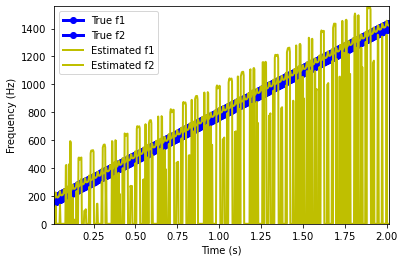

[ 13.66932655 528.53338713]


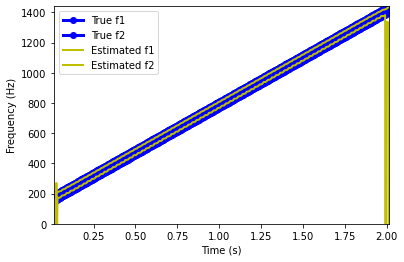

[0.91080218 1.8128723 ]
[[ 204.0531053   151.33628685]
 [ 202.8390422   154.39650228]
 [ 201.82029268  158.70414237]
 ...
 [1429.90578744 1332.97928008]
 [1432.54800284 1334.65451854]
 [1435.00824691    0.        ]]


"\nEn la primera crida observem que el meanError és molt superior a 2.\nEn el segon test, augmentem el tamany de la window fins a 3401 per d'aquesta manera tenir un meanError per sota de 2.\n"

In [71]:
# E5 - 2.1: First call function freq_tracker_error() with the test case values and plot the true versus the 
# estimated frequency values, then change the window-size to obtain minimum possible error, and plot the new 
# estimated frequency values. Explain the choice and result.


import matplotlib.pyplot as plt
H = 128 
window = 'blackman'
t = -80 
input_file = '../sounds/chirp-150-190-linear.wav'
fs, x = UF.wavread(input_file) 
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_chirp_150_190(tStamps) #true freq values

### Your code here

#Test case
M = 1023
meanError, fTrackEst = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

N = int(pow(2, np.ceil(np.log2(M))))        
maxplotfreq = 1500.0
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.plot(tStamps,fTrackTrue, 'o-', color = 'b', linewidth=3.0)
plt.plot(tStamps,fTrackEst, color = 'y', linewidth=2.0)
plt.legend(('True f1', 'True f2', 'Estimated f1', 'Estimated f2'))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.autoscale(tight=True)
plt.show()

print(meanError)

#------------------------------------------------------------------------------------
M = 3401
meanError, fTrackEst2 = freq_tracker_error(input_file, fTrackTrue, window, t, H, M)

N = int(pow(2, np.ceil(np.log2(M))))        
maxplotfreq = 1500.0
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.plot(tStamps,fTrackTrue, 'o-', color = 'b', linewidth=3.0)
plt.plot(tStamps,fTrackEst2, color = 'y', linewidth=2.0)
plt.legend(('True f1', 'True f2', 'Estimated f1', 'Estimated f2'))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.autoscale(tight=True)
plt.show()

print(meanError)
#print(fTrackEst2)
"""
En la primera crida observem que el meanError és molt superior a 2.
En el segon test, augmentem el tamany de la window fins a 3401 per d'aquesta manera tenir un meanError per sota de 2.
"""


## Part 3 -Tracking sinusoids of different amplitudes 

In this part you should perform the best possible sinusoidal analysis of a signal with two sinusoidal components of different amplitudes by focusing on the type of window `window` and the magnitude threshold `t` of the function `sineModelAnal()`. 

Use the input signal `sines-440-602-hRange.wav` which includes two sinusoidal components with a very large difference in their amplitude. It is a synthetically generated signal with frequency components 440Hz and 602Hz, `s = sin(2*pi*440*t) + 2e-3*sin(2*pi*602*t)`. 

This part uses the same functions as Part 2.

Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or sonic visualizer to see its spectrogram. Notice the difference in the amplitudes of its components.

To do this exercise complete the next cell. Run the function `freq_tracker_error()` giving a value for the window type `window` and the  magnitude threshold `t`. Use the given values for the rest of parameters.

For the `sineModelAnal()` function we use a window length `M = 2047` samples, an FFT size `N = 4096` samples, and a hop size `H = 128` samples. For sine tracking, we set `minSineDur = 0.02` seconds, `freqDevOffset = 10`Hz, and `freqDevSlope = 0.001` (its default value). Since we need only two frequency component estimates at every frame, we set `maxnSines = 2`. 

Set the input parameters `window` and `t` such that the mean estimation error of each frequency components is less than 2Hz. There is a range of values of `M` and `t` for which this is true and all of those values will be considered correct answers. You can plot the estimated and true frequency tracks to visualize the accuracy of estimation. The output is the set of parameters you used: `window`, `t`, the time stamps, estimated and the true frequency tracks. Note that choosing the wrong window might lead to tracking of one of the sidelobes of the high amplitude sinusoid instead of the mainlobe of the low amplitude sinusoid. 

For the window, choose one of `'boxcar'`, `'hanning'`, `'hamming'`, `'blackman'`, or `'blackmanharris'`. `t` should be specified in negative dB.

NOTE: Do not do just trial and error. Understand the problem and calculate and `M` that should work. Then test it and refine the answer.

__Test case:__ Choosing `window = 'hanning'`, `t = -80.0`, the mean estimation error is `[0.19603701  29.51140815]` Hz. 


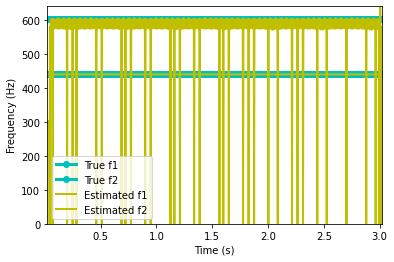

[ 0.19603701 29.51140815]


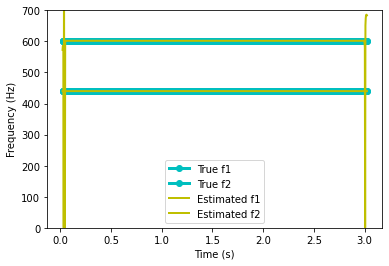

[0.03843794 0.06193923]


'Explanation\nPodem veure que a la primera estimació aquests paràmetres consegueixen aproximar molt bé la primera freq pero no la segona.\nSi fem servir el mateix t = -80.0 dB però canviem la window a blackmanharris podem veure que el error és més petit que 1.\n'

In [97]:
# E5 - 3.1: First call freq_tracker_error() with the values for the test case and plot the true versus the 
# estimated frequency values. Then choose the window and threshold to obtain minimum possible error, and plot 
# the new estimated frequency values. Explain the result.
    
M = 2047                                             # Window size 
N = 4096                                             # FFT Size
H = 128                                              # Hop size in samples
t = -80.0
input_file = '../sounds/sines-440-602-hRange.wav'
fs, x = UF.wavread(input_file)  
tStamps = gen_time_stamps(x.size, M, fs, H)   # Generate the tStamps to return
fTrackTrue = gen_true_freq_tracks_440_602 (tStamps)

### Your code here

meanError, fTrackEst = freq_tracker_error(input_file, fTrackTrue, 'hanning', t, H, M)
maxplotfreq = 1500.0
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.plot(tStamps,fTrackTrue, 'o-', color = 'c', linewidth=3.0)
plt.plot(tStamps,fTrackEst, color = 'y', linewidth=2.0)
plt.legend(('True f1', 'True f2', 'Estimated f1', 'Estimated f2'))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.autoscale(tight=True)
plt.show()
print(meanError)
#------------------------------------------------------------------------------------
t = -80.0
meanError, fTrackEst2 = freq_tracker_error(input_file, fTrackTrue, 'blackmanharris', t, H, M)
maxplotfreq = 1500.0
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.plot(tStamps,fTrackTrue, 'o-', color = 'c', linewidth=3.0)
plt.plot(tStamps,fTrackEst2, color = 'y', linewidth=2.0)
plt.legend(('True f1', 'True f2', 'Estimated f1', 'Estimated f2'))
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.ylim(0,700)
plt.show()

print(meanError)

"""Explanation
Podem veure que a la primera estimació aquests paràmetres consegueixen aproximar molt bé la primera freq pero no la segona.
Si fem servir el mateix t = -80.0 dB però canviem la window a blackmanharris podem veure que el error és més petit que 1.
"""

## Part 4 - Sinusoidal modeling of a multicomponent signal

In this part you will perform a sinusoidal analysis of a complex synthetic signal, using `sineModelAnal()` exploring the different parameters of the model. Use the sound `multiSines.wav` and explain the difficulties encoutered and solutions found. 

This is an open question without a single specific answer. We will use the sound `multiSines.wav`, which is a synthetic audio signal with sharp attacks, close frequency components with a wide range of amplitudes, and time varying chirps with frequency tracks that cross over. All these characteristics make this signal difficult to analyze with `sineModelAnal()`. Get familiar with the signal by listening to it and visualizing its spectrogram. Use `models_GUI.py` interface or Sonic Visualizer to see its spectrogram. 

We have written a basic code for sinusoidal analysis, you are free to modify it. You should be able to generate a sound that is perceptually undistinguishable from the input sound.


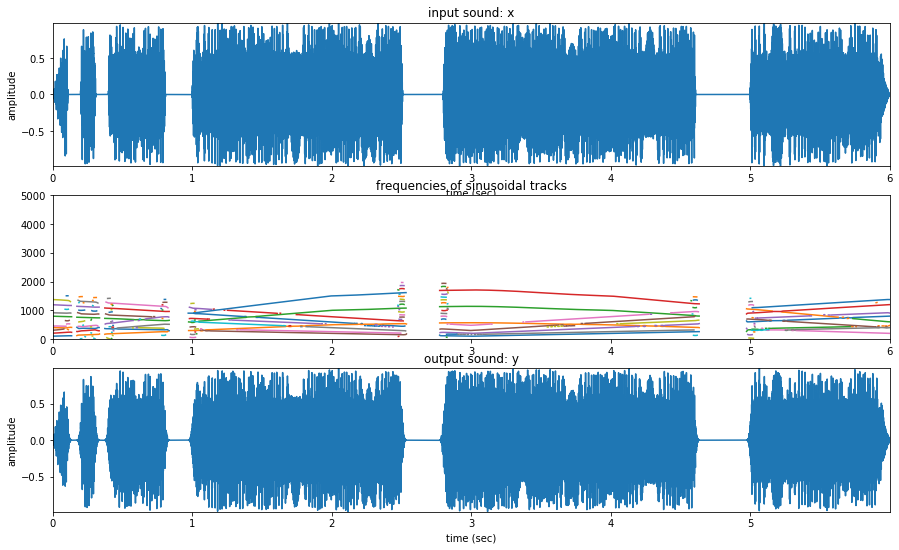

In [100]:
# E5 - 4.1: Set the analysis parameters of sineModelAnal() to perform the best analysis of multiSines.wav

import IPython.display as ipd

input_file = '../sounds/multiSines.wav'

### set the analysis parameters

window = 'blackmanharris'                       
M = 3401                                           
N = 4096                                                                                     
t = -80.0
maxnSines = 30                            # Maximum number of sinusoids at any time frame
minSineDur = 0.0                            # minimum duration set to zero to not do tracking
freqDevOffset = 30                          # minimum frequency deviation at 0Hz
freqDevSlope = 0.001


# no need to modify the code after here
Ns = 512                                      # size of fft used in synthesis
H = 128                                       # hop size (has to be 1/4 of Ns)
    
fs, x = UF.wavread(input_file)                # read input sound
w = get_window(window, M)                     # compute analysis window

# analyze the sound with the sinusoidal model
tfreq, tmag, tphase = SM.sineModelAnal(x, fs, w, N, H, t, maxnSines, minSineDur, freqDevOffset, freqDevSlope)

# synthesize the output sound from the sinusoidal representation
y = SM.sineModelSynth(tfreq, tmag, tphase, Ns, H, fs)

# create figure to show plots
plt.figure(figsize=(15, 9))

# frequency range to plot
maxplotfreq = 5000.0

# plot the input sound
plt.subplot(3,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')
                
# plot the sinusoidal frequencies
plt.subplot(3,1,2)
if (tfreq.shape[1] > 0):
    numFrames = tfreq.shape[0]
    frmTime = H*np.arange(numFrames)/float(fs)
    tfreq[tfreq<=0] = np.nan
    plt.plot(frmTime, tfreq)
    plt.axis([0, x.size/float(fs), 0, maxplotfreq])
    plt.title('frequencies of sinusoidal tracks')

# plot the output sound
plt.subplot(3,1,3)
plt.plot(np.arange(y.size)/float(fs), y)
plt.axis([0, y.size/float(fs), min(y), max(y)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('output sound: y')

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))

In [ ]:
# Your explanation of Part 4 here

'''
Per fer l'anàlisi hem fet servir els mateixos valors que en els apartats anteriors i els que es troben en les funcions ja definides.
Un cop fet això simplement hem anat pujant el nombres de sinusoides fins que escoltem totes les freqüències.

'''